In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data_file_path = 'welddb/welddb.data'
headers_file_path = 'welddb/headers.txt'
with open(headers_file_path, 'r') as f:
    headers = [line.strip() for line in f]
df = pd.read_csv(data_file_path, sep=r'\s+', header=None, names=headers)

In [5]:
df

,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Nickel concentration (weight%),Chromium concentration (weight%),Molybdenum concentration (weight%),Vanadium concentration (weight%),Copper concentration (weight%),...,Charpy temperature (deg C),Charpy impact toughness (J),Hardness (kgmm-2),50 % FATT,Primary ferrite in microstructure (%),Ferrite with second phase (%),Acicular ferrite (%),Martensite (%),Ferrite with carbide aggregate (%),Weld ID
0,0.037,0.30,0.65,0.008,0.012,0,N,N,N,N,...,N,N,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0,N,N,N,N,...,-28,100,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0,N,N,N,N,...,-38,100,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0,N,N,N,N,...,N,N,N,N,N,N,N,N,N,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0,N,N,N,N,...,-48,100,N,N,32,28,40,0,0,Evans-Ni/CMn-1990/1991-0Bawch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,N,...,N,N,N,N,N,N,N,N,N,Birmingham-MAX35
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,N,...,N,N,N,N,N,N,N,N,N,Birmingham-MAX36
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,N,...,N,N,N,N,N,N,N,N,N,Birmingham-MAX37
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,N,...,N,N,N,N,N,N,N,N,N,Birmingham-MAX38


First, we will replace the N values with a nan variable

In [6]:
#Replace missing values with NaN
df.replace('N', np.nan, inplace=True)

Let's see the vartiables types so that we can convert the types of the variables to the right format

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1652 non-null   float64
 1   Silicon concentration (weight%)               1652 non-null   float64
 2   Manganese concentration (weight%)             1652 non-null   float64
 3   Sulphur concentration (weight%)               1648 non-null   object 
 4   Phosphorus concentration (weight%)            1642 non-null   object 
 5   Nickel concentration (weight%)                697 non-null    object 
 6   Chromium concentration (weight%)              784 non-null    object 
 7   Molybdenum concentration (weight%)            793 non-null    object 
 8   Vanadium concentration (weight%)              928 non-null    object 
 9   Copper concentration (weight%)                578 non-null    o

We should convert all te numerical variables to numerical type, but let's see this column

In [8]:
#see the 1197th row
df.loc[1197]

Carbon concentration (weight%)                             0.06
Silicon concentration (weight%)                            0.32
Manganese concentration (weight%)                          1.23
Sulphur concentration (weight%)                          <0.002
Phosphorus concentration (weight%)                        0.002
Nickel concentration (weight%)                             1.01
Chromium concentration (weight%)                            8.4
Molybdenum concentration (weight%)                         0.89
Vanadium concentration (weight%)                           0.22
Copper concentration (weight%)                            <0.01
Cobalt concentration (weight%)                            <0.01
Tungsten concentration (weight%)                            NaN
Oxygen concentration (ppm)                                  380
Titanium concentration (ppm)                               <100
Nitrogen concentration (ppm)                                 80
Aluminium concentration (ppm)           

Some lines that are expected to have numerical values may contain some non numerical one (like the '<0.002' value assigned to the variable 'Sulphur concentration (weight%)' for the 1197th row of the dataframe)

First, we will convert only possible rows then we will treat the rest

In [9]:
#Convert the variables to numeric if possible
df = df.apply(pd.to_numeric, errors='ignore')

C:\Users\moham\AppData\Local\Temp\ipykernel_3832\1754603372.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1652 non-null   float64
 1   Silicon concentration (weight%)               1652 non-null   float64
 2   Manganese concentration (weight%)             1652 non-null   float64
 3   Sulphur concentration (weight%)               1648 non-null   object 
 4   Phosphorus concentration (weight%)            1642 non-null   float64
 5   Nickel concentration (weight%)                697 non-null    float64
 6   Chromium concentration (weight%)              784 non-null    float64
 7   Molybdenum concentration (weight%)            793 non-null    object 
 8   Vanadium concentration (weight%)              928 non-null    object 
 9   Copper concentration (weight%)                578 non-null    o

We can see that already 23 columns have no problems.
Now, we will deal with the other numerical columns that may contain some anomalies (like the '<' in the last example)

First, we will remove the '<' symbole from numerical variables

In [11]:
df.replace({r'<': '', }, regex=True, inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')


C:\Users\moham\AppData\Local\Temp\ipykernel_3832\2566959729.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1652 non-null   float64
 1   Silicon concentration (weight%)               1652 non-null   float64
 2   Manganese concentration (weight%)             1652 non-null   float64
 3   Sulphur concentration (weight%)               1648 non-null   float64
 4   Phosphorus concentration (weight%)            1642 non-null   float64
 5   Nickel concentration (weight%)                697 non-null    float64
 6   Chromium concentration (weight%)              784 non-null    float64
 7   Molybdenum concentration (weight%)            793 non-null    float64
 8   Vanadium concentration (weight%)              928 non-null    float64
 9   Copper concentration (weight%)                578 non-null    f

We still have 7 'object' type columns, let's explore them

In [13]:
object_columns = df.select_dtypes(include=['object']).columns

df[object_columns]

,Nitrogen concentration (ppm),AC or DC,Electrode positive or negative,Interpass temperature (deg C),Type of weld,Hardness (kgmm-2),Weld ID
0,NaN,DC,+,200,MMA,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,NaN,DC,+,200,MMA,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,NaN,DC,+,200,MMA,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,NaN,DC,+,200,MMA,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,NaN,DC,+,200,MMA,NaN,Evans-Ni/CMn-1990/1991-0Bawch
...,...,...,...,...,...,...,...
1647,398,NaN,+,200,SA,NaN,Birmingham-MAX35
1648,394,NaN,+,200,SA,NaN,Birmingham-MAX36
1649,96,NaN,+,200,SA,NaN,Birmingham-MAX37
1650,99,NaN,+,200,SA,NaN,Birmingham-MAX38


We can see that the 3 columns 'Nitrogen concentration (ppm)', 'Interpass temperature (deg C)' and 'Hardness (kgmm-2)' should have numerical values.
Let's see what are the non-numerical values in these columns

In [14]:
list_of_numeric_columns = ['Nitrogen concentration (ppm)', 'Interpass temperature (deg C)', 'Hardness (kgmm-2)']

In [15]:
#see all the unique values in the these columns
for column in list_of_numeric_columns:
    print(column, df[column].unique())
    print('\n')

Nitrogen concentration (ppm) [nan '72' '54' '57' '47' '44' '46' '68' '55' '53' '50' '48' '52' '89' '70'
 '41' '38' '80' '49' '77' '94' '65' '67' '58' '60' '460' '480' '160' '155'
 '67tot33res' '66totndres' '61tot34res' '54totndres' '54tot24res'
 '52tot18res' '50tot17res' '48tot18res' '78' '88' '75' '84' '85' '79' '76'
 '83' '92' '74' '86' '90' '110' '97' '99' '91' '105' '120' '150' '81' '87'
 '93' '102' '96' '66' '73' '71' '82' '145' '148' '164' '166' '235' '226'
 '243' '239' '253' '249' '240' '100' '143' '119' '539' '515' '494' '489'
 '552' '517' '520' '544' '526' '537' '529' '509' '523' '107' '114' '106'
 '117' '125' '95' '109' '64' '36' '63' '43' '39' '34' '69' '59' '37' '51'
 '56' '140' '190' '170' '124' '133' '108' '61' '122' '121' '131' '101'
 '103' '116' '138' '139' '62' '136' '540' '180' '450' '370' '250' '400'
 '430' '420' '410' '390' '260' '340' '26' '22' '21' '35' '127' '156' '245'
 '312' '266' '123' '236' '165' '113' '269' '45' '27' '42' '98' '373' '376'
 '416' '398' '394']

Let's adress the first column : 'Nitrogen concentration (ppm)'

In [57]:
df1 = df.copy()

In [52]:
# Find the non-numeric entries in 'Nitrogen concentration (ppm)'
df1['Nitrogen concentration (ppm)_numeric'] = pd.to_numeric(df1['Nitrogen concentration (ppm)'], errors='coerce')

# Identify rows where the conversion resulted in NaN (indicating non-numeric values)
problematic_entries = df1[df1['Nitrogen concentration (ppm)_numeric'].isna() & ~df1['Nitrogen concentration (ppm)'].isna()]['Nitrogen concentration (ppm)'].unique()

df1 = df1.drop(columns=['Nitrogen concentration (ppm)_numeric'])

problematic_entries  

array(['N', '67tot33res', '66totndres', '61tot34res', '54totndres',
       '54tot24res', '52tot18res', '50tot17res', '48tot18res'],
      dtype=object)

After extensive investigation into the meaning of these values, we discovered through various articles that the notation XtotYres is an abbreviation for X total and Y residual. This indicates that the nitrogen concentration in the material is divided into two components: the total concentration (X) and the residual concentration (Y), which remains after some process (nd stands for non-detected).

For the purpose of our analysis, we will focus on the total concentration (X), as it represents the complete amount of nitrogen present in the material before any processes or reactions occur. The residual concentration often reflects secondary or incomplete reactions and is typically less representative of the material's initial state or overall chemical composition. By considering the total concentration, we ensure that our analysis captures the full nitrogen content, which is more relevant for evaluating the material's properties and predicting weld quality.

(we have only 59 values containing residual concentations, we don't need to consider the residual concentration as a new independant variable)


We will therefore replace the values of these cases with the total concentration (X)

In [18]:
# convert the problematic entries to numeric

def converter(x):
    try:
        return float(x)
    except:
        return float(x[:2])

In [19]:
df['Nitrogen concentration (ppm)'] = df['Nitrogen concentration (ppm)'].apply(converter)

In [20]:
df['Nitrogen concentration (ppm)']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
1647    398.0
1648    394.0
1649     96.0
1650     99.0
1651    103.0
Name: Nitrogen concentration (ppm), Length: 1652, dtype: float64

Now, all 'Nitrogen concentration (ppm)' values are numerical


Let's adress the second column : Interpass temperature (deg C)

In [21]:
df1 = df.copy()

In [22]:
# Find the non-numeric entries in 'Nitrogen concentration (ppm)'
df1['Interpass temperature (deg C)_numeric'] = pd.to_numeric(df1['Interpass temperature (deg C)'], errors='coerce')

# Identify rows where the conversion resulted in NaN (indicating non-numeric values)
problematic_entries = df1[df1['Interpass temperature (deg C)_numeric'].isna() & ~df1['Interpass temperature (deg C)'].isna()]['Interpass temperature (deg C)'].unique()

df1 = df1.drop(columns=['Interpass temperature (deg C)_numeric'])

problematic_entries  

array(['150-200'], dtype=object)

The only non-numerical value here is :  '150-200'

In [23]:
# see the rows with a value of '150-200' in 'Interpass temperature (deg C)'
df1[df1['Interpass temperature (deg C)'] == '150-200'].head()

,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Nickel concentration (weight%),Chromium concentration (weight%),Molybdenum concentration (weight%),Vanadium concentration (weight%),Copper concentration (weight%),...,Charpy temperature (deg C),Charpy impact toughness (J),Hardness (kgmm-2),50 % FATT,Primary ferrite in microstructure (%),Ferrite with second phase (%),Acicular ferrite (%),Martensite (%),Ferrite with carbide aggregate (%),Weld ID
1166,0.08,0.45,0.96,0.007,0.015,0.21,9.1,0.96,0.19,0.03,...,NaN,NaN,459Hv10,NaN,2.0,NaN,NaN,NaN,NaN,PantK-1990-w1
1167,0.10,0.54,0.66,0.006,0.014,0.31,9.0,0.82,0.23,0.02,...,NaN,NaN,405Hv10,NaN,11.0,NaN,NaN,NaN,NaN,PantK-1990-w2
1168,0.09,0.46,0.99,0.012,0.021,0.22,9.5,0.96,0.19,0.03,...,NaN,NaN,451Hv10,NaN,4.0,NaN,NaN,NaN,NaN,PantK-1990-w3
1169,0.09,0.37,1.03,0.004,0.010,0.05,8.8,1.03,0.25,0.01,...,NaN,NaN,432Hv10,NaN,12.0,NaN,NaN,NaN,NaN,PantK-1990-w4.0
1170,0.09,0.37,1.03,0.004,0.010,0.05,8.8,1.03,0.25,0.01,...,NaN,NaN,264Hv10,NaN,NaN,NaN,NaN,NaN,NaN,PantK-1990-w4.1


This variable, Interpass temperature (°C), describes the temperature of the material between multiple passes of the welding process. Maintaining a consistent interpass temperature is critical for ensuring the quality and mechanical properties of the weld. In some rows, the recorded value for this variable is given as a range, such as 150-200°C, rather than a single temperature. Since we need a numerical value for further analysis, we will transform this interval into its median value, which in this case is 175°C. This allows us to approximate the interpass temperature while ensuring that the data remains consistent and usable for modeling purposes.

In [24]:
def converter(x):
    try:
        return float(x)
    except:
        return 175

In [25]:
df['Interpass temperature (deg C)'] = df['Interpass temperature (deg C)'].apply(converter)
df['Interpass temperature (deg C)']

0       200.0
1       200.0
2       200.0
3       200.0
4       200.0
        ...  
1647    200.0
1648    200.0
1649    200.0
1650    200.0
1651    200.0
Name: Interpass temperature (deg C), Length: 1652, dtype: float64

Now, all 'Interpass temperature (deg C)' values are numerical


Let's adress the third column : Hardness (kgmm-2)

In [26]:
df1 = df.copy()

In [27]:
# Find the non-numeric entries in 'Nitrogen concentration (ppm)'
df1['Hardness (kgmm-2)_numeric'] = pd.to_numeric(df1['Hardness (kgmm-2)'], errors='coerce')

# Identify rows where the conversion resulted in NaN (indicating non-numeric values)
problematic_entries = df1[df1['Hardness (kgmm-2)_numeric'].isna() & ~df1['Hardness (kgmm-2)'].isna()]['Hardness (kgmm-2)'].unique()

df1 = df1.drop(columns=['Hardness (kgmm-2)_numeric'])

problematic_entries  

array(['158(Hv30)', '155(Hv30)', '153(Hv30)', '161(Hv30)', '168(Hv30)',
       '203(Hv30)', '157(Hv30)', '174(Hv30)', '144(Hv30)', '143(Hv30)',
       '154(Hv30)', '170(Hv30)', '459Hv10', '405Hv10', '451Hv10',
       '432Hv10', '264Hv10', '241Hv10', '251Hv10', '225Hv10', '233Hv10',
       '208Hv10', '373Hv10', '224Hv10', '210Hv10', '212Hv10', '202Hv10',
       '204Hv10', '201Hv10', '398Hv10', '249Hv10', '226Hv10', '234Hv10',
       '219Hv10', '467Hv10', '277Hv10', '254Hv10', '263Hv10', '237Hv10',
       '362Hv10', '291Hv10', '262Hv10', '266Hv10', '253Hv10', '257Hv10',
       '246Hv10', '264Hv5', '269Hv5', '233Hv5', '226Hv5'], dtype=object)

In [28]:
# remove ( and ) from the 'Hardness (kgmm-2)' column
df['Hardness (kgmm-2)'] = df['Hardness (kgmm-2)'].str.replace('(', '')
df['Hardness (kgmm-2)'] = df['Hardness (kgmm-2)'].str.replace(')', '')


<Axes: xlabel='Hardness (kgmm-2)'>

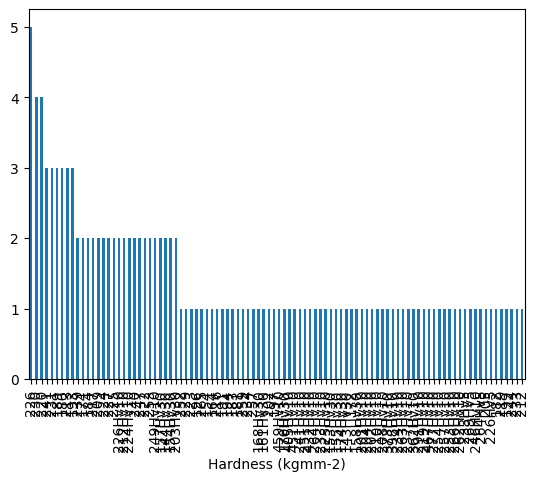

In [29]:
#plot categorical data

df['Hardness (kgmm-2)'].value_counts().plot(kind='bar')

In [30]:
#count the number of missing values

df['Hardness (kgmm-2)'].isnull().sum()

np.int64(1514)

In [31]:
df1 = df.copy()

In [32]:
df1['Hardness (kgmm-2)_numeric'] = pd.to_numeric(df1['Hardness (kgmm-2)'], errors='coerce')

# Identify rows where the conversion resulted in NaN (indicating non-numeric values)
problematic_entries = df1[df1['Hardness (kgmm-2)_numeric'].isna() & ~df1['Hardness (kgmm-2)'].isna()]['Hardness (kgmm-2)'].unique()

df1 = df1.drop(columns=['Hardness (kgmm-2)_numeric'])

problematic_entries  

array(['158Hv30', '155Hv30', '153Hv30', '161Hv30', '168Hv30', '203Hv30',
       '157Hv30', '174Hv30', '144Hv30', '143Hv30', '154Hv30', '170Hv30',
       '459Hv10', '405Hv10', '451Hv10', '432Hv10', '264Hv10', '241Hv10',
       '251Hv10', '225Hv10', '233Hv10', '208Hv10', '373Hv10', '224Hv10',
       '210Hv10', '212Hv10', '202Hv10', '204Hv10', '201Hv10', '398Hv10',
       '249Hv10', '226Hv10', '234Hv10', '219Hv10', '467Hv10', '277Hv10',
       '254Hv10', '263Hv10', '237Hv10', '362Hv10', '291Hv10', '262Hv10',
       '266Hv10', '253Hv10', '257Hv10', '246Hv10', '264Hv5', '269Hv5',
       '233Hv5', '226Hv5'], dtype=object)


In this column, we have two types of hardness values:

1. **Numerical values**: These are already standardized, such as `257`, `153`, etc.
2. **Mixed values**: These values are formatted as `xHVy` (e.g., `150Hv30`), where `x` is the hardness value and `y` is the load in kgf used during the test.

We need to standardize all the values in this column so that they are comparable, assuming a standard load of **10 kgf**.

We will use the following formula to standardize values to a common load (e.g., 10 kgf):



$$
Hv_{\text{standard}} = Hv_{\text{measured}} \times \left( \frac{L_{\text{standard}}}{L_{\text{measured}}} \right)^n
$$

Where:
- $ Hv_{\text{standard}} $ is the standardized hardness value.
- $ Hv_{\text{measured}} $ is the hardness value measured at a specific load.
- $  L_{\text{standard}} $ is the standard load we will choose (in this case, **10 kgf**).
- $  L_{\text{measured}} $ is the load used during the measurement (extracted from the notation `xHVy`).
- $  n  $ is an empirical constant, typically around **0.2** for metals.



For values that don't mention a load (e.g., `257`), we will assume the default load used was **10 kgf**, meaning no adjustment is necessary.


In [33]:
n=0.2
L_standard = 10

def transformer(x):
    try:
        return float(x)
    except:
        if x != np.nan :
            liste=x.split('Hv')
            L_measured = float(liste[1])
            HV_measured = float(liste[0])
            return HV_measured*((L_standard/L_measured)**n)

In [34]:
df['Hardness (kgmm-2)'] = df['Hardness (kgmm-2)'].apply(transformer)
df['Hardness (kgmm-2)'].unique()

array([         nan, 257.        , 227.        , 224.        ,
       226.        , 234.        , 217.        , 213.        ,
       209.        , 259.        , 239.        , 223.        ,
       230.        , 252.        , 241.        , 231.        ,
       229.        , 180.        , 174.        , 220.        ,
       184.        , 193.        , 189.        , 181.        ,
       183.        , 194.        , 216.        , 191.        ,
       164.        , 154.        , 265.        , 225.        ,
       196.        , 202.        , 197.        , 172.        ,
       126.83316676, 124.42494207, 122.81945895, 129.24139144,
       134.86058238, 162.95653704, 126.0304252 , 139.67703175,
       115.59478489, 114.79204333, 123.62220051, 136.4660655 ,
       459.        , 405.        , 451.        , 432.        ,
       264.        , 251.        , 233.        , 208.        ,
       373.        , 210.        , 212.        , 204.        ,
       201.        , 398.        , 249.        , 219.  

Well done, now the hardness column is float type

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1652 non-null   float64
 1   Silicon concentration (weight%)               1652 non-null   float64
 2   Manganese concentration (weight%)             1652 non-null   float64
 3   Sulphur concentration (weight%)               1648 non-null   float64
 4   Phosphorus concentration (weight%)            1642 non-null   float64
 5   Nickel concentration (weight%)                697 non-null    float64
 6   Chromium concentration (weight%)              784 non-null    float64
 7   Molybdenum concentration (weight%)            793 non-null    float64
 8   Vanadium concentration (weight%)              928 non-null    float64
 9   Copper concentration (weight%)                578 non-null    f

let's see the remaining object columns

In [36]:
object_columns = df.select_dtypes(include=['object']).columns

df[object_columns]

,AC or DC,Electrode positive or negative,Type of weld,Weld ID
0,DC,+,MMA,Evans-Ni/CMn-1990/1991-0Aaw
1,DC,+,MMA,Evans-Ni/CMn-1990/1991-0Aawch
2,DC,+,MMA,Evans-Ni/CMn-1990/1991-0Aht
3,DC,+,MMA,Evans-Ni/CMn-1990/1991-0Baw
4,DC,+,MMA,Evans-Ni/CMn-1990/1991-0Bawch
...,...,...,...,...
1647,NaN,+,SA,Birmingham-MAX35
1648,NaN,+,SA,Birmingham-MAX36
1649,NaN,+,SA,Birmingham-MAX37
1650,NaN,+,SA,Birmingham-MAX38


In [37]:
#onehot encoding to ac vs dc and Electrode positive or negative

df222 = pd.get_dummies(df, columns=['AC or DC', 'Electrode positive or negative'])[['AC or DC_AC',	'AC or DC_DC', 'Electrode positive or negative_+', 'Electrode positive or negative_-',	'Electrode positive or negative_0']]


<Axes: >

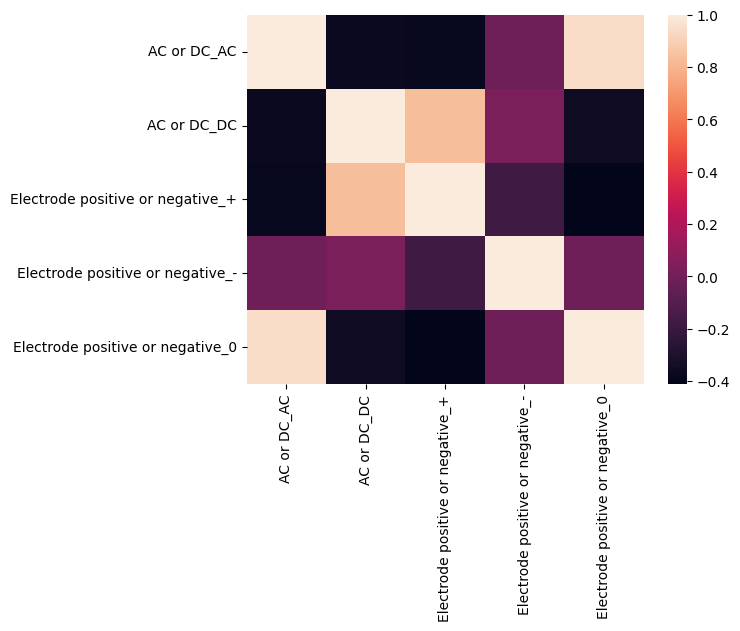

In [38]:
# correlation matrix plot 

import seaborn as sns

corr = df222.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


we can see that the column ac or dc is correlated with the eletrode column, we will consider only the electrode column

In [39]:
df.drop(columns=['AC or DC'], inplace=True)

In [40]:
df = pd.get_dummies(df, columns=['Electrode positive or negative'])

Since we want to build a prediction model, we should deal with other categorical variables, let's adress the Type of weld column

In [41]:
# see all the unique values in the 'Type of weld' column
df['Type of weld'].unique()

array(['MMA', 'ShMA', 'FCA', 'SA', 'TSA', 'SAA', 'GTAA', 'GMAA', 'NGSAW',
       'NGGMA'], dtype=object)

In [42]:
#onehot encoding to 'Type of weld' column

df = pd.get_dummies(df, columns=['Type of weld'])

In [43]:
# see the columns names

df.head()

,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Nickel concentration (weight%),Chromium concentration (weight%),Molybdenum concentration (weight%),Vanadium concentration (weight%),Copper concentration (weight%),...,Type of weld_FCA,Type of weld_GMAA,Type of weld_GTAA,Type of weld_MMA,Type of weld_NGGMA,Type of weld_NGSAW,Type of weld_SA,Type of weld_SAA,Type of weld_ShMA,Type of weld_TSA
0,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
1,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
2,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
3,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
4,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1652 non-null   float64
 1   Silicon concentration (weight%)               1652 non-null   float64
 2   Manganese concentration (weight%)             1652 non-null   float64
 3   Sulphur concentration (weight%)               1648 non-null   float64
 4   Phosphorus concentration (weight%)            1642 non-null   float64
 5   Nickel concentration (weight%)                697 non-null    float64
 6   Chromium concentration (weight%)              784 non-null    float64
 7   Molybdenum concentration (weight%)            793 non-null    float64
 8   Vanadium concentration (weight%)              928 non-null    float64
 9   Copper concentration (weight%)                578 non-null    f

Let's explore more the variables

Based on related articles in the domain of welding and materials science, it is common to handle missing values of certain chemical elements differently. For instance:

- Missing values of **Phosphorus (P)** and **Sulphur (S)** are imputed using the **mean values** from the dataset.
- Other missing values of other elements such as **Manganese (Mn)**, **Nickel (Ni)**, etc., are set to **0** because these elements are not deliberately added and are likely close to the detection limit of the analytical techniques used.

Therefore, we will implement this preprocessing step to ensure that the dataset is correctly handled for the prediction task.

In [62]:
df['Sulphur concentration (weight%)'] = df['Sulphur concentration (weight%)'].fillna(df['Sulphur concentration (weight%)'].mean())
df['Phosphorus concentration (weight%)'] = df['Phosphorus concentration (weight%)'].fillna(df['Phosphorus concentration (weight%)'].mean())

# Replace missing values for all other concentrations with 0 (as they were not deliberately added)
elements_to_zero = ['Manganese concentration (weight%)', 'Sulphur concentration (weight%)',
       'Phosphorus concentration (weight%)', 'Nickel concentration (weight%)',
       'Chromium concentration (weight%)', 'Molybdenum concentration (weight%)',
       'Vanadium concentration (weight%)', 'Copper concentration (weight%)',
       'Cobalt concentration (weight%)', 'Tungsten concentration (weight%)',
       'Oxygen concentration (ppm)', 'Titanium concentration (ppm)',
       'Nitrogen concentration (ppm)', 'Aluminium concentration (ppm)',
       'Boron concentration (ppm)', 'Niobium concentration (ppm)',
       'Tin concentration (ppm)', 'Arsenic concentration (ppm)',
       'Antimony concentration (ppm)']

# Replace missing values with 0 for the other elements
df[elements_to_zero] = df[elements_to_zero].fillna(0)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1652 non-null   float64
 1   Silicon concentration (weight%)               1652 non-null   float64
 2   Manganese concentration (weight%)             1652 non-null   float64
 3   Sulphur concentration (weight%)               1652 non-null   float64
 4   Phosphorus concentration (weight%)            1652 non-null   float64
 5   Nickel concentration (weight%)                1652 non-null   float64
 6   Chromium concentration (weight%)              1652 non-null   float64
 7   Molybdenum concentration (weight%)            1652 non-null   float64
 8   Vanadium concentration (weight%)              1652 non-null   float64
 9   Copper concentration (weight%)                1652 non-null   f

In [66]:
# transformer les bool en int

liste=['Electrode positive or negative_+', 'Electrode positive or negative_-', 'Electrode positive or negative_0', 'Type of weld_FCA', 'Type of weld_GMAA', 'Type of weld_GTAA', 'Type of weld_MMA', 'Type of weld_NGGMA', 'Type of weld_NGSAW', 'Type of weld_SA', 'Type of weld_SAA', 'Type of weld_ShMA', 'Type of weld_TSA']

for i in liste:
    df[i]=df[i].astype(int)


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 54 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1652 non-null   float64
 1   Silicon concentration (weight%)               1652 non-null   float64
 2   Manganese concentration (weight%)             1652 non-null   float64
 3   Sulphur concentration (weight%)               1652 non-null   float64
 4   Phosphorus concentration (weight%)            1652 non-null   float64
 5   Nickel concentration (weight%)                1652 non-null   float64
 6   Chromium concentration (weight%)              1652 non-null   float64
 7   Molybdenum concentration (weight%)            1652 non-null   float64
 8   Vanadium concentration (weight%)              1652 non-null   float64
 9   Copper concentration (weight%)                1652 non-null   f

In [69]:
# save the cleaned data to a new file

df.to_csv('welddb/welddb_cleaned.csv', index=False)